CLASSIFYING NAMES WITH A CHARACTER-LEVEL RNN  
https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial  

baesd on the spelling, classify which language a name is from  

In [1]:
from io import open
import glob
import os

In [3]:
glob.glob('data/names/*.txt')

['data/names/Czech.txt',
 'data/names/German.txt',
 'data/names/Arabic.txt',
 'data/names/Japanese.txt',
 'data/names/Chinese.txt',
 'data/names/Vietnamese.txt',
 'data/names/Russian.txt',
 'data/names/French.txt',
 'data/names/Irish.txt',
 'data/names/English.txt',
 'data/names/Spanish.txt',
 'data/names/Greek.txt',
 'data/names/Italian.txt',
 'data/names/Portuguese.txt',
 'data/names/Scottish.txt',
 'data/names/Dutch.txt',
 'data/names/Korean.txt',
 'data/names/Polish.txt']

In [56]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

In [21]:
unicodeToAscii('Málaga')

'Malaga'

In [29]:
print(unicodeToAscii('Ślusàrski'))

Slusarski


In [48]:
category_lines = {}
all_categories = []

In [41]:
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

In [49]:
for filename in glob.glob('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

In [43]:
os.path.splitext(os.path.basename('data/names/Czech.txt'))

('Czech', '.txt')

In [50]:
category_lines

{'Czech': ['Abl',
  'Adsit',
  'Ajdrna',
  'Alt',
  'Antonowitsch',
  'Antonowitz',
  'Bacon',
  'Ballalatak',
  'Ballaltick',
  'Bartonova',
  'Bastl',
  'Baroch',
  'Benesch',
  'Betlach',
  'Biganska',
  'Bilek',
  'Blahut',
  'Blazek',
  'Blazek',
  'Blazejovsky',
  'Blecha',
  'Bleskan',
  'Blober',
  'Bock',
  'Bohac',
  'Bohunovsky',
  'Bolcar',
  'Borovka',
  'Borovski',
  'Borowski',
  'Borovsky',
  'Brabbery',
  'Brezovjak',
  'Brousil',
  'Bruckner',
  'Buchta',
  'Cablikova',
  'Camfrlova',
  'Cap',
  'Cerda',
  'Cermak',
  'Chermak',
  'Cermak',
  'Cernochova',
  'Cernohous',
  'Cerny',
  'Cerney',
  'Cerny',
  'Cerv',
  'Cervenka',
  'Chalupka',
  'Charlott',
  'Chemlik',
  'Chicken',
  'Chilar',
  'Chromy',
  'Cihak',
  'Clineburg',
  'Klineberg',
  'Cober',
  'Colling',
  'Cvacek',
  'Czabal',
  'Damell',
  'Demall',
  'Dehmel',
  'Dana',
  'Dejmal',
  'Dempko',
  'Demko',
  'Dinko',
  'Divoky',
  'Dolejsi',
  'Dolezal',
  'Doljs',
  'Dopita',
  'Drassal',
  'Driml',
  

a single letter -> one-hot vector  
'b' = [0, 1, 0, ...] with len=26 for english letter b  
a word -> 2D array of one-hot vector of (len(word), 26)

In [51]:
import torch

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,;'"

In [53]:
def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    # a line is a name
    tensor = torch.zeros(len(line), 1, n_letters)  # the second axis is the batch dimension
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [57]:
print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


In [63]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)  # input to hidden
        self.i2o = nn.Linear(input_size + hidden_size, output_size)  # input to output
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [66]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8927, -2.8769, -2.9312, -2.9779, -2.9615, -2.9286, -2.8234, -2.8847,
         -2.9157, -2.8547, -2.8260, -2.7842, -2.8664, -2.8234, -2.8930, -2.9736,
         -2.8458, -2.9988]], grad_fn=<LogSoftmaxBackward>)


In [80]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

In [81]:
print(categoryFromOutput(output))

('Greek', 11)


In [82]:
import random

In [85]:
def randomChoice(l):
    return l[random.randint(0, len(l)-1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

category = Italian / line = Berardi
category = Polish / line = Gorecki
category = English / line = Heywood
category = Irish / line = Eoin
category = Polish / line = Majewski
category = English / line = Groom
category = English / line = Ranks
category = English / line = Hirst
category = Russian / line = Tzeitlin
category = Czech / line = Kolacny


In [86]:
criterion = nn.NLLLoss()

In [105]:
# from scratch, each character in a word is passed one by one

learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    for i in range(line_tensor.size()[0]):  # the len of a word
        output, hidden = rnn(line_tensor[i], hidden)
    # a sequence consists of characters
    
    loss = criterion(output, category_tensor)
    loss.backward()
    
    # implementing optimizer.step()
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
        
    return output, loss.item()

In [106]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

In [107]:
current_loss = 0
all_losses = []

In [108]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = s // 60
    s -= m * 60
    return f"{m}m {s}s"

In [109]:
start = time.time()

for iter in range(1, n_iters+1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0.0m 5.27488899230957s) 2.8800 Close / French ✗ (Greek)
10000 10% (0.0m 10.478137731552124s) 2.6988 O'Neal / Scottish ✗ (Irish)
15000 15% (0.0m 16.04412078857422s) 2.9522 Matos / Greek ✗ (Portuguese)
20000 20% (0.0m 21.737226963043213s) 0.3534 Fujimaki / Japanese ✓
25000 25% (0.0m 28.059072971343994s) 2.1438 Dael / German ✗ (Dutch)
30000 30% (0.0m 34.23350667953491s) 1.7902 Mclean / Irish ✗ (Scottish)
35000 35% (0.0m 40.5395188331604s) 1.0909 Abalakin / Russian ✓
40000 40% (0.0m 49.085444688797s) 1.3376 Oirschotten / Dutch ✓
45000 45% (0.0m 55.0973687171936s) 1.0552 Antoun / Arabic ✓
50000 50% (1.0m 0.9782898426055908s) 1.2764 Janick / Czech ✓
55000 55% (1.0m 6.791364669799805s) 1.3173 Ngo / Vietnamese ✓
60000 60% (1.0m 12.995750904083252s) 3.5452 Soucy / English ✗ (French)
65000 65% (1.0m 18.106966018676758s) 0.9561 Zhou / Chinese ✓
70000 70% (1.0m 23.34233808517456s) 2.6394 Guthrie / French ✗ (English)
75000 75% (1.0m 28.273250818252563s) 0.4783 Serafini / Italian ✓
80000 80

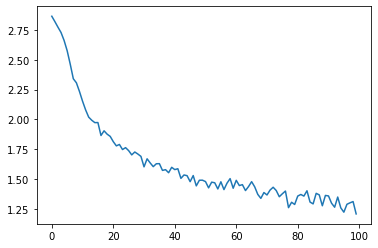

In [110]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

In [111]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line):
    hidden = rnn.initHidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1
    
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

<ipython-input-119-e41783a62d49>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-119-e41783a62d49>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


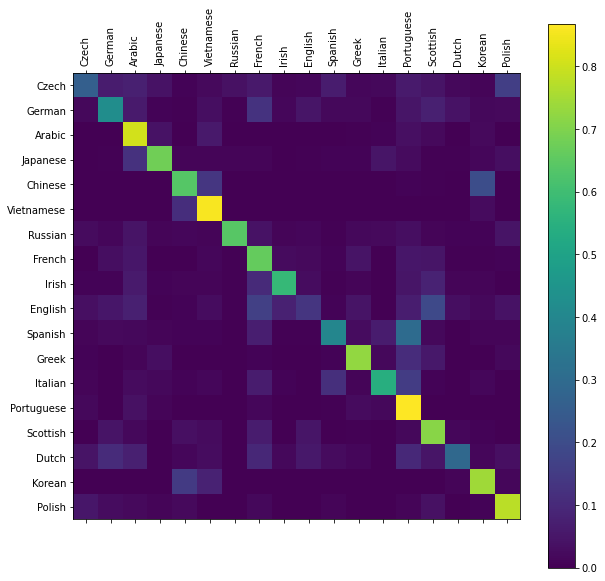

In [119]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)  # the first element in the list degenerates
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [149]:
def predict(input_line, n_predictions=3):
    print(f"\n> {input_line}")
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print(f"{value:.2f} {all_categories[category_index]}")
            predictions.append([value, all_categories[category_index]])
            
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


 Dovesky
-0.40 Vietnamese
-1.44 Chinese
-2.82 Korean

 Jackson
-0.40 Vietnamese
-1.44 Chinese
-2.82 Korean

 Satoshi
-0.40 Vietnamese
-1.44 Chinese
-2.82 Korean


In [151]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

In [152]:
predict('Hazaki')


> Hazaki
(-0.40) Vietnamese
(-1.44) Chinese
(-2.82) Korean


In [136]:
output.topk(3, 1, True)

torch.return_types.topk(
values=tensor([[-0.3992, -1.4423, -2.8158]], grad_fn=<TopkBackward>),
indices=tensor([[ 5,  4, 16]]))

In [145]:
torch.randn(10,10,10).topk(2, 1).values.shape

torch.Size([10, 2, 10])

In [147]:
output.shape

torch.Size([1, 18])